# RF model results

In this notebook we visualize actual model output

In [1]:
import glob
import os
import pyart
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib
import pickle

%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# suppress anoying iypthon warnings. Not ideal since we suppress also potentially relevant warnings
import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/exts-ml2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Some global variables

In [3]:
model_path = './RF_models/balanced_RF_f1_expanded.pickle'
fbasepath = '/data/pyrad_products/MSG_ML/'
features = ['HRV_norm', 'HRV_norm_text', 'IR_108', 'IR_108_text', 'WV_062-IR_108', 'WV_062-IR_108_text', 'IR_016', 'IR_016_text']
nfeatures = len(features)
target = 'POH90'

## Auxiliary functions

In [4]:
# Function to read original dataset
# data is stored as (nz, ny, nx), we return (nx, ny)
def read_nc(fname):
    sat_grid = pyart.io.read_grid(fname)
    for field_name in sat_grid.fields.keys():
        data = np.transpose(np.squeeze(sat_grid.fields[field_name]['data']))
    return data        

In [5]:
# Function for minmax scaling
def minmax_scaling(data, vmin, vmax):
    data2 = deepcopy(data)
    data2[data2>vmax] = vmax
    data2[data2<vmin] =vmin
    return data2-vmin/(vmax-vmin)

In [6]:
# Filter data where IR temperature too high or channel differences too negative
def filter_data(X, y, ir_thr=240, diff_thr=-50):
    # Find row indexes of elements to delete
    ind = []
    ind_ir = np.where(X[:, 2] > ir_thr)
    if len(ind_ir[0]) > 0:
        ind.extend(ind_ir[0])
    ind_diff = np.where(X[:, 4] < diff_thr)
    if len(ind_diff[0]) > 0:
        ind.extend(ind_diff[0])
        
    # Remove NaNs
    # NaNs can appear in texture fields.
    # They could safely be considered 0s but we remove them
    for i in range(X.shape[1]):
        ind_nan = np.where(np.isnan(X[:, i]))
        if len(ind_nan[0]) > 0:
            ind.extend(ind_nan[0])
            
    if len(ind) == 0:
        return X, y
    
    ind = np.array(ind)
    ind = np.unique(ind)
    
    # delete from feature matrix
    X2 = np.delete(X, ind, axis=0)
    
    # delete from target matrix
    y2 = np.delete(y, ind, axis=0)
    
    print('removed '+str(len(ind))+' pixels out of '+str(y.size)+' from dataset')
    
    return X2, y2, ind

In [7]:
def plot_data(data, data_name, vmin=None, vmax=None, cmap=None, norm=None, ticks=None, ticklabs=None, fig=None, ax=None):
    if fig is None:
        fig = plt.figure()
        ax = plt.subplot()
    cax = ax.pcolormesh(data.T, vmin=vmin, vmax=vmax, cmap=cmap, norm=norm)
    ax.set_title(data_name)
    ax.set_aspect('equal', 'box')
    plt.axis('off')
    cb = fig.colorbar(cax, ax=ax)
    if ticks is not None:
        cb.set_ticks(ticks)
    if ticklabs is not None:
        cb.set_ticklabels(ticklabs)
    #plt.show()

## Randomly select an image set

In [8]:
flist = glob.glob(fbasepath+'*/NETCDF/'+features[0]+'/*.nc')
ind = np.random.randint(0, len(flist))
fnames_features = [flist[ind]]
# Get time step
bfile = os.path.basename(fnames_features[0])
dt_str = bfile[0:14]
print('selected time step:', dt_str)
for feature in features[1:]:
    flist = glob.glob(fbasepath+'*/NETCDF/'+feature+'/'+dt_str+'*.nc')
    fnames_features.append(flist[0])

fname_target = glob.glob(fbasepath+'*/NETCDF/'+target+'/'+dt_str+'*.nc')[0]

selected time step: 20180608134500


## Get data, features and target matrix

In [9]:
img_shape = read_nc(fnames_features[0]).shape
img_size = img_shape[0]*img_shape[1]
X = np.empty((img_size, nfeatures), dtype=np.float32)
data_list = []
for i, fname in enumerate(fnames_features):
    data_aux = read_nc(fname)
    data_list.append(data_aux)
    X[:, i] = data_aux.flatten()

target_data = read_nc(fname_target)
y = target_data.flatten()

X, y, ind_filtered = filter_data(X, y)

# put 1 (hail probability computed but below 90%) to 0 and 2 (hail probability above 90%) to 1
y[y == 1] = 0
y[y == 2] = 1

removed 97719 pixels out of 114688 from dataset


## Get model

In [10]:
with open(model_path, 'rb') as bfile:
    rf_model_best = pickle.load(bfile)

## Test model on individual image

In [11]:
# Report test score
acc_RF = rf_model_best.score(X, y)
print('Test score:', acc_RF)

Test score: 0.8280982968943368


In [12]:
y_pred = rf_model_best.predict(X)

In [13]:
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

In [14]:
print('True positive: ', tp)
print('True negative: ', tn)
print('False positive: ', fp)
print('False negative: ', fn)
print('Positive pixels: ', y[y == 1].size)
print('Negative pixels: ', y[y == 0].size)

True positive:  45
True negative:  14007
False positive:  2914
False negative:  3
Positive pixels:  48
Negative pixels:  16921


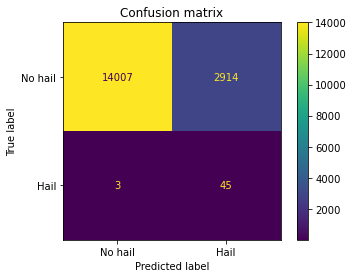

In [15]:
disp = plot_confusion_matrix(rf_model_best, X, y, labels=[0, 1], display_labels=['No hail', 'Hail'], normalize=None)
disp.ax_.set_title('Confusion matrix')
plt.show()

In [16]:
pod = 100*tp/(tp+fn)
far = 100*fp/(fp+tn)
ppv = tp/(tp+fp)
print('Probability of Detection (POD):', pod)
print('False Alarm Rate (FAR):', far)
print('Positive Predictive Value (PPV):', ppv)

Probability of Detection (POD): 93.75
False Alarm Rate (FAR): 17.22120442054252
Positive Predictive Value (PPV): 0.015207840486650895


## Plot features, target and prediction

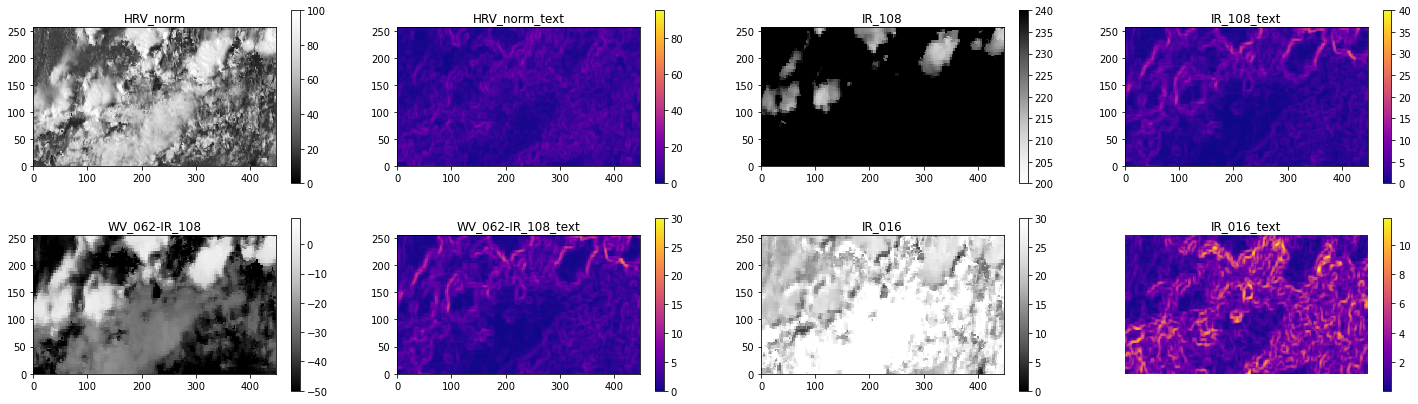

In [17]:
ncol = 4
nrow = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(25,7))

for i, (feature_data, feature_name) in enumerate(zip (data_list, features)):
    icol = i%ncol
    irow = int(i/ncol)
    
    if feature_name == 'HRV_norm':
        vmin = 0
        vmax = 100
        cmap = 'Greys_r'
    elif feature_name == 'HRV_norm_text':
        vmin = 0
        vmax = 95
        cmap = 'plasma'
    elif feature_name == 'IR_108':
        vmin = 200
        vmax = 240
        cmap = 'Greys'
    elif feature_name == 'IR_108_text':
        vmin = 0
        vmax = 40
        cmap = 'plasma'
    elif feature_name == 'WV_062-IR_108':
        vmin = -50
        vmax = 9
        cmap = 'Greys_r'
    elif feature_name == 'WV_062-IR_108_text':
        vmin = 0
        vmax = 30
        cmap = 'plasma'
    elif feature_name == 'IR_016':
        vmin = 0
        vmax = 30
        cmap = 'Greys_r'
    elif feature_name == 'IR_016_text':
        vmin = None
        vmax = None
        cmap = 'plasma'
    else:
        vmin= None
        vmax = None
        cmap = None
    plot_data(feature_data, feature_name, vmin=vmin, vmax=vmax, cmap=cmap, fig=fig, ax=ax[irow, icol])

In [18]:
# Create predicted image
pred_data = np.ones(img_size, dtype=np.uint8)  # flat image
pred_data[ind_filtered] = 0  # pixels not entering model are set to 0
pred_data = pred_data.reshape(img_shape)  # reshape to actual image shape
pred_data[pred_data == 1] = y_pred+1  # pixels predicted are given the results of the prediction

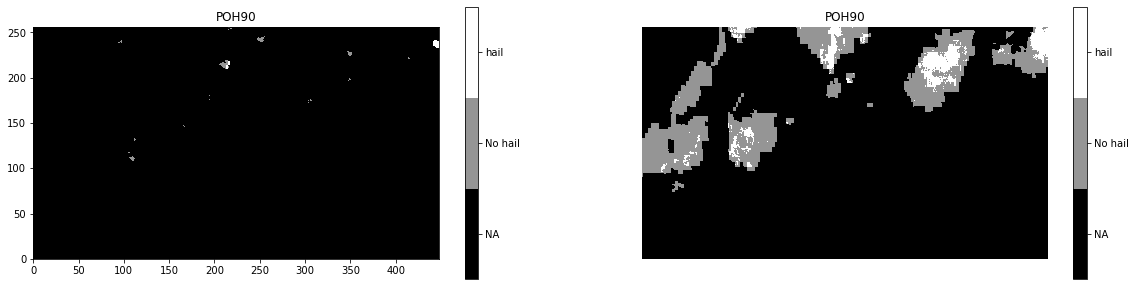

In [19]:
field_dict = {
    'ticks': [0, 1, 2],
    'boundaries': [-0.5, 0.5, 1.5, 2.5],
    'labels': ['NA', 'No hail', 'hail']
}

cmap = matplotlib.cm.get_cmap('Greys_r')
norm = matplotlib.colors.BoundaryNorm(
            boundaries=field_dict['boundaries'], ncolors=cmap.N)

fig, ax = plt.subplots(1, 2, figsize=(20,5))
plot_data(target_data, target, cmap=cmap, norm=norm, ticks=field_dict['ticks'], ticklabs=field_dict['labels'], fig=fig, ax=ax[0])
plot_data(pred_data, target, cmap=cmap, norm=norm, ticks=field_dict['ticks'], ticklabs=field_dict['labels'], fig=fig, ax=ax[1])